## Testing for GPU

In [1]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob

In [4]:
%matplotlib inline

import os, json
from glob import glob
import numpy as np

import keras

from tensorflow.keras import optimizers

from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16


from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from tensorflow.python.keras.models import Model,load_model,Sequential

from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.python.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [7]:
import cv2
import seaborn as sns
# import shapely.wkt
# import shapely.affinity
# from shapely.geometry import MultiPolygon, Polygon
# from collections import defaultdict
# from shapely.wkt import loads as wkt_loads
# import tifffile as tiff

## Import kaggle dataset
### Use only for Colab or without preloaded datasets

In [8]:
# Next, install the Kaggle API client.
# !pip install -q kaggle

In [9]:
# !ls

In [10]:
# from google.colab import files
# files.upload()

In [11]:
# # The Kaggle API client expects this file to be in ~/.kaggle,
# # so move it there.
# !mkdir -p ~/.kaggle
# !mv kaggle.json ~/.kaggle/

# # This permissions change avoids a warning on Kaggle tool startup.
# !chmod 600 ~/.kaggle/kaggle.json

In [12]:
# List available datasets.
# !kaggle datasets list

In [13]:
# !kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [14]:
#import kaggle

In [15]:
# !ls

## Shift the raw files to input folder

In [16]:
# !mkdir -p input

In [17]:
# !mv  chest-xray-pneumonia.zip input

In [18]:
# !ls input

In [19]:
# !ls -a

In [20]:
# !unzip -u input/chest-xray-pneumonia.zip -d input/

In [21]:
# !unzip -u -q input/chest_xray.zip -d input/

In [22]:
# !ls input/chest_xray/

## Pre-processing

In [23]:
path_train = "input/chest_xray/train"
path_val = "input/chest_xray/val"
path_test = "input/chest_xray/test"

In [24]:
img = glob(path_train+"/PNEUMONIA/*.jpeg")

In [25]:
img = np.asarray(plt.imread(img[0]))

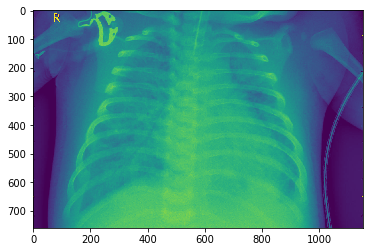

In [26]:
plt.imshow(img)

In [27]:
#Training Data
filenames_n0 = glob(path_train+"/NORMAL/*.jpeg")
filenames_n1 = glob(path_train+"/PNEUMONIA/*.jpeg")

names = ['NORMAL', 'PNEUMONIA']

In [28]:
# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []
val_data = []

In [29]:
# Go through all the normal cases. The label for these cases will be 0
for img in filenames_n0:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in filenames_n1:
    train_data.append((img, 1))

In [30]:
# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,input/chest_xray/train/PNEUMONIA\person965_bac...,1
1,input/chest_xray/train/PNEUMONIA\person539_bac...,1
2,input/chest_xray/train/PNEUMONIA\person18_bact...,1
3,input/chest_xray/train/PNEUMONIA\person964_bac...,1
4,input/chest_xray/train/NORMAL\IM-0649-0001.jpeg,0


In [31]:
#Validation Data
filenames_v0 = glob(path_val+"/NORMAL/*.jpeg")
filenames_v1 = glob(path_val+"/PNEUMONIA/*.jpeg")

In [32]:
# Go through all the normal cases. The label for these cases will be 0
for img in filenames_v0:
    val_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in filenames_v1:
    val_data.append((img, 1))

In [33]:
# Get a pandas dataframe from the data we have in our list 
val_data = pd.DataFrame(val_data, columns=['image', 'label'],index=None)

# Shuffle the data 
val_data = val_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
val_data.head()

,image,label
0,input/chest_xray/val/NORMAL\NORMAL2-IM-1427-00...,0
1,input/chest_xray/val/NORMAL\NORMAL2-IM-1437-00...,0
2,input/chest_xray/val/PNEUMONIA\person1954_bact...,1
3,input/chest_xray/val/NORMAL\NORMAL2-IM-1442-00...,0
4,input/chest_xray/val/NORMAL\NORMAL2-IM-1431-00...,0


## Information on Dataset

1    3875
0    1341
Name: label, dtype: int64


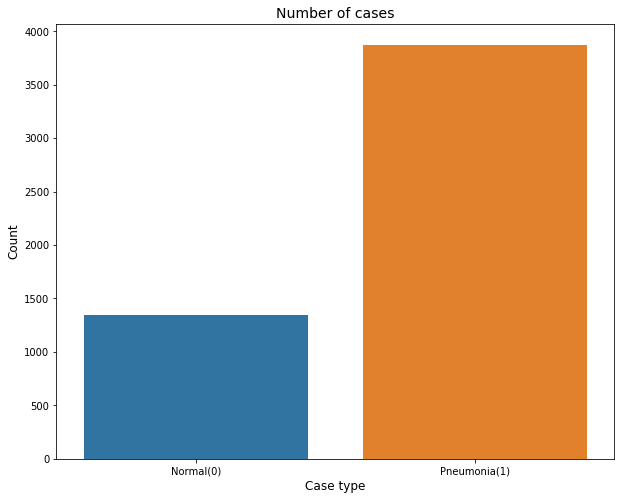

In [34]:
# Get the counts for each class
cases_count = train_data['label'].value_counts()
print(cases_count)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [35]:
# # Make a dataframe based on the filenames
df = pd.DataFrame(filenames_n0, columns = ["filename"])
df2 = pd.DataFrame(filenames_n1, columns = ["filename"])

val_df = pd.DataFrame(filenames_v0, columns = ["filename"])
val_df2 = pd.DataFrame(filenames_v1, columns = ["filename"])


# # Add Class columns 
df['class'] = pd.Series([0 for x in range(len(df.index))], index=df.index)
df2['class'] = pd.Series([1 for x in range(len(df2.index))], index=df2.index)

val_df['class'] = pd.Series([0 for x in range(len(val_df.index))], index=val_df.index)
val_df2['class'] = pd.Series([1 for x in range(len(val_df2.index))], index=val_df2.index)



# # Split into train and validation sets
# train_set_percentage = 0.95


# train_df = df[:int(len(df)*train_set_percentage)]
# val_df = df[int(len(df)*train_set_percentage):]

# train_df2 = df2[:int(len(df2)*train_set_percentage)]
# val_df2 = df2[int(len(df2)*train_set_percentage):]



# df_new_train = pd.concat([train_df, train_df2])
# df_new_val = pd.concat([val_df, val_df2])

df_new_train = pd.concat([df, df2])
df_new_val = pd.concat([val_df, val_df2])

In [36]:
# shuffle 
df = df_new_train.sample(frac=1).reset_index(drop=True)
df_val = df_new_val.sample(frac=1).reset_index(drop=True)

In [37]:
len(df)

5216

In [38]:
len(df_val)

16

In [39]:
df.head()

,filename,class
0,input/chest_xray/train/PNEUMONIA\person808_vir...,1
1,input/chest_xray/train/PNEUMONIA\person524_vir...,1
2,input/chest_xray/train/PNEUMONIA\person393_vir...,1
3,input/chest_xray/train/PNEUMONIA\person1484_ba...,1
4,input/chest_xray/train/PNEUMONIA\person1103_vi...,1


In [40]:
# convert the dataframe into 2 lists to use for filename and labels
train_filenames_list = df["filename"].tolist()
train_labels_list = df["class"].astype('int32').tolist()

# convert the dataframe into 2 lists to use for filename and labels
val_filenames_list = df_val["filename"].tolist()
val_labels_list = df_val["class"].astype('int32').tolist()

#number of classes
num_classes = 2

df.shape

(5216, 2)

In [41]:
df_val.shape

(16, 2)

In [42]:
df.head()

,filename,class
0,input/chest_xray/train/PNEUMONIA\person808_vir...,1
1,input/chest_xray/train/PNEUMONIA\person524_vir...,1
2,input/chest_xray/train/PNEUMONIA\person393_vir...,1
3,input/chest_xray/train/PNEUMONIA\person1484_ba...,1
4,input/chest_xray/train/PNEUMONIA\person1103_vi...,1


In [43]:
train_filenames_list[:5]

['input/chest_xray/train/PNEUMONIA\\person808_virus_1442.jpeg',
 'input/chest_xray/train/PNEUMONIA\\person524_virus_1045.jpeg',
 'input/chest_xray/train/PNEUMONIA\\person393_virus_784.jpeg',
 'input/chest_xray/train/PNEUMONIA\\person1484_bacteria_3878.jpeg',
 'input/chest_xray/train/PNEUMONIA\\person1103_virus_1825.jpeg']

## Make the pipeline for loading, resizing and augmenting the images

In [44]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 299,299

def _parse_function(filename, label):
  image_string = tf.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string, channels=3)
  
  # This will convert to float values in [0, 1]
  image_zo = tf.image.convert_image_dtype(image_decoded, tf.float32)
  image_resized = tf.image.resize_images(image_zo, [img_rows, img_cols])
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [45]:
# train preprocess
def train_preprocess(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image,0.5,1.5)
    
    image = tf.image.random_brightness(image, max_delta=32.0 / 255.0)
    image = tf.image.random_saturation(image, lower=0.5, upper=1.5)

    # Make sure the image is still in [0, 1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

In [46]:
# A vector of filenames - from a list
filenames = tf.constant(train_filenames_list)

# Labels that match the training files - from a list
labels = tf.constant(train_labels_list)

# Same as above but for validation set
val_filenames = tf.constant(val_filenames_list)
val_labels = tf.constant(val_labels_list)

In [47]:
# val_labels_list

## Assembling the Data pipeline using tf.data

In [48]:
train_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
train_dataset = train_dataset.map(_parse_function,num_parallel_calls=4)
train_dataset = train_dataset.map(train_preprocess, num_parallel_calls=4)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(16)
train_dataset = train_dataset.prefetch(1)

In [49]:
valid_dataset = tf.data.Dataset.from_tensor_slices((val_filenames, val_labels))
valid_dataset = valid_dataset.map(_parse_function,num_parallel_calls=4)
valid_dataset = valid_dataset.map(train_preprocess, num_parallel_calls=4)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(16)
valid_dataset = valid_dataset.prefetch(1)

## Load Model - Pretrained models

In [50]:
# from keras.applications.nasnet import NASNetMobile, preprocess_input, decode_predictions

# model_imagenet = NASNetMobile(weights='imagenet', include_top=True)   # 24,226,656 bytes
# print("Model Loaded")

In [51]:
# from tensorflow.keras.applications import VGG16

In [52]:
# InceptionV3 Model - trained on image net
base_model = InceptionV3(weights='imagenet', include_top=False)

In [53]:
# base_model.summary()http://login.live.com/login.srf?wa=wsignin1.0&rpsnv=11&ct=1274684751&rver=5.5.4177.0&wp=MBI&wreply=http:%2F%2Fhome.live.com%2F&lc=1033&id=251248

In [54]:
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)

# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
# 2 Classes for chest x-ray
predictions = Dense(num_classes, activation='softmax')(x)

In [55]:
# Creating the model that we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [56]:
for layer in base_model.layers:
    layer.trainable = False

In [57]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable);

0 input_1 False
1 conv2d False
2 batch_normalization False
3 activation False
4 conv2d_1 False
5 batch_normalization_1 False
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 False
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 False
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 False
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 False
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 False
24 batch_normalization_9 False
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 False
33 batch_normalization_7 False
34 batch_normalization_10 False
35 batch_normalization_11 False
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 False

In [58]:
# model.summary()

## Training the top layer

In [59]:
opt = optimizers.Adam(lr=0.001)

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [60]:
batch_size = 16
lr = 0.001

train_steps = df.shape[0]//batch_size
val_steps = df_val.shape[0]//batch_size
epochs = 10
es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='input/toptune_weights_{epoch:02d}_{val_acc:.2f}_{val_loss:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

In [61]:
# # # Train the model with validation 
model.fit(train_dataset, steps_per_epoch = train_steps,
                 epochs = epochs,
                 validation_data = valid_dataset,
                 validation_steps = val_steps,class_weight='auto',
                 callbacks=[chkpt])

Epoch 1/10
325/326 [============================>.] - ETA: 0s - loss: 0.3566 - acc: 0.8556
Epoch 00001: val_loss improved from inf to 1.40210, saving model to input/toptune_weights_01_0.50_1.40.hdf5
326/326 [==============================] - 58s 178ms/step - loss: 0.3563 - acc: 0.8558 - val_loss: 1.4021 - val_acc: 0.5000
Epoch 2/10
325/326 [============================>.] - ETA: 0s - loss: 0.2367 - acc: 0.9029
Epoch 00002: val_loss did not improve from 1.40210
326/326 [==============================] - 44s 134ms/step - loss: 0.2370 - acc: 0.9026 - val_loss: 1.8864 - val_acc: 0.5000
Epoch 3/10
325/326 [============================>.] - ETA: 0s - loss: 0.2146 - acc: 0.9138
Epoch 00003: val_loss improved from 1.40210 to 1.16552, saving model to input/toptune_weights_03_0.56_1.17.hdf5
326/326 [==============================] - 43s 132ms/step - loss: 0.2148 - acc: 0.9137 - val_loss: 1.1655 - val_acc: 0.5625
Epoch 4/10
325/326 [============================>.] - ETA: 0s - loss: 0.1992 - acc: 

In [62]:
for i, layer in enumerate(model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [63]:
# for layer in model.layers[:249]:
#    layer.trainable = False
# for layer in model.layers[249:]:
#    layer.trainable = True

## Fine tuning the model

In [64]:
# Freeze the InceptionV3 layers in the new model except the BatchNorm
for layer in model.layers:
    if 'batch' in layer.name:
#       print(layer.name)
      layer.trainable = True
    else:
      layer.trainable = False

In [65]:
for i, layer in enumerate(model.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 conv2d False
2 batch_normalization True
3 activation False
4 conv2d_1 False
5 batch_normalization_1 True
6 activation_1 False
7 conv2d_2 False
8 batch_normalization_2 True
9 activation_2 False
10 max_pooling2d False
11 conv2d_3 False
12 batch_normalization_3 True
13 activation_3 False
14 conv2d_4 False
15 batch_normalization_4 True
16 activation_4 False
17 max_pooling2d_1 False
18 conv2d_8 False
19 batch_normalization_8 True
20 activation_8 False
21 conv2d_6 False
22 conv2d_9 False
23 batch_normalization_6 True
24 batch_normalization_9 True
25 activation_6 False
26 activation_9 False
27 average_pooling2d False
28 conv2d_5 False
29 conv2d_7 False
30 conv2d_10 False
31 conv2d_11 False
32 batch_normalization_5 True
33 batch_normalization_7 True
34 batch_normalization_10 True
35 batch_normalization_11 True
36 activation_5 False
37 activation_7 False
38 activation_10 False
39 activation_11 False
40 mixed0 False
41 conv2d_15 False
42 batch_normalization_15 True
43 activatio

In [66]:
metrics = model.evaluate(valid_dataset,steps = val_steps)
print("model accuracy:",metrics[1])

1/1 [==============================] - 0s 177ms/step
model accuracy: 0.5


In [67]:
# opt = optimizers.Adam(lr=0.001,decay=0.3,amsgrad=True)
opt = optimizers.Nadam()
model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

In [68]:
epochs = 60
es = EarlyStopping(patience=10)
chkpt = ModelCheckpoint(filepath='input/finetune_weights_{epoch:02d}_{val_acc:.2f}_{val_loss:.2f}.hdf5', verbose=1, save_best_only=True, mode='auto')
chkpt2 = ModelCheckpoint(filepath='input/finetune_weights_last_only.hdf5', verbose=1, save_best_only=False, mode='auto')
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

In [69]:
model.fit(train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps, #class_weight='auto',
                   callbacks=[chkpt, chkpt2])

Epoch 1/60
325/326 [============================>.] - ETA: 0s - loss: 0.1308 - acc: 0.9477
Epoch 00001: val_loss improved from inf to 3.25306, saving model to input/finetune_weights_01_0.50_3.25.hdf5

Epoch 00001: saving model to input/finetune_weights_last_only.hdf5
326/326 [==============================] - 59s 180ms/step - loss: 0.1308 - acc: 0.9477 - val_loss: 3.2531 - val_acc: 0.5000
Epoch 2/60
325/326 [============================>.] - ETA: 0s - loss: 0.0953 - acc: 0.9646
Epoch 00002: val_loss improved from 3.25306 to 1.42256, saving model to input/finetune_weights_02_0.56_1.42.hdf5

Epoch 00002: saving model to input/finetune_weights_last_only.hdf5
326/326 [==============================] - 49s 151ms/step - loss: 0.0952 - acc: 0.9647 - val_loss: 1.4226 - val_acc: 0.5625
Epoch 3/60
325/326 [============================>.] - ETA: 0s - loss: 0.0802 - acc: 0.9685
Epoch 00003: val_loss improved from 1.42256 to 0.57769, saving model to input/finetune_weights_03_0.75_0.58.hdf5

Epoch 0

326/326 [==============================] - 50s 152ms/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0488 - val_acc: 0.9375
Epoch 24/60
325/326 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9988
Epoch 00024: val_loss did not improve from 0.04885

Epoch 00024: saving model to input/finetune_weights_last_only.hdf5
326/326 [==============================] - 49s 149ms/step - loss: 0.0047 - acc: 0.9988 - val_loss: 0.0958 - val_acc: 0.9375
Epoch 25/60
325/326 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9979
Epoch 00025: val_loss improved from 0.04885 to 0.02693, saving model to input/finetune_weights_25_1.00_0.03.hdf5

Epoch 00025: saving model to input/finetune_weights_last_only.hdf5
326/326 [==============================] - 49s 151ms/step - loss: 0.0055 - acc: 0.9979 - val_loss: 0.0269 - val_acc: 1.0000
Epoch 26/60
325/326 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9975
Epoch 00026: val_loss did not improve from 0.02693



In [70]:
# Preparing test data

normal_cases = glob(path_test+"/NORMAL/*.jpeg")
pneumonia_cases = glob(path_test+"/PNEUMONIA/*.jpeg")

In [71]:
from tensorflow.keras.utils import to_categorical

In [72]:
test_data = []
test_labels = []

for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
                      
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data.append(img)
    test_labels.append(label)
    

test_data = np.array(test_data)
test_labels = np.array(test_labels)

print("Total number of test examples: ", test_data.shape)
print("Total number of labels:", test_labels.shape)

Total number of test examples:  (624, 224, 224, 3)
Total number of labels: (624, 2)


In [83]:
model.load_weights("input/finetune_weights_60_1.00_0.00.hdf5")

In [84]:
test_loss, test_score = model.evaluate(test_data, test_labels, batch_size=16)
print("Loss on test set: ", test_loss)
print("Accuracy on test set: ", test_score)

624/624 [==============================] - 1s 2ms/step
Loss on test set:  1.177397702171267
Accuracy on test set:  0.8477564102564102


In [85]:
# Get predictions
preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_labels, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

(624,)
(624,)


In [86]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [87]:
# Get the confusion matrix
cm  = confusion_matrix(orig_test_labels, preds)

In [88]:
cm

array([[145,  89],
       [  6, 384]], dtype=int64)

<Figure size 432x288 with 0 Axes>

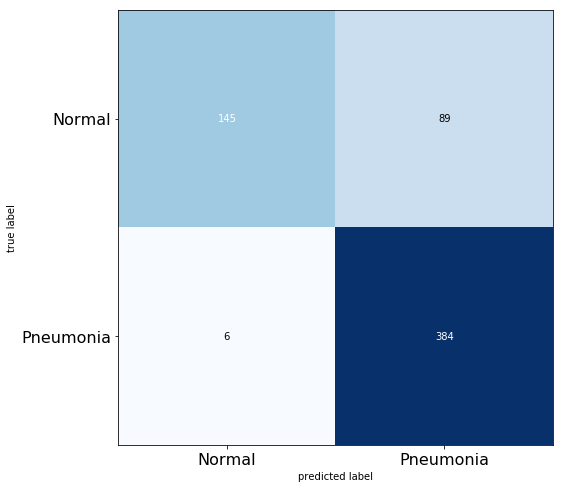

In [89]:
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [90]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.98
Precision of the model is 0.81


## History log of fine-tuning

In [91]:
# Epoch 1/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.1308 - acc: 0.9477
# Epoch 00001: val_loss improved from inf to 3.25306, saving model to input/finetune_weights_01_0.50_3.25.hdf5

# Epoch 00001: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 59s 180ms/step - loss: 0.1308 - acc: 0.9477 - val_loss: 3.2531 - val_acc: 0.5000
# Epoch 2/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0953 - acc: 0.9646
# Epoch 00002: val_loss improved from 3.25306 to 1.42256, saving model to input/finetune_weights_02_0.56_1.42.hdf5

# Epoch 00002: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 151ms/step - loss: 0.0952 - acc: 0.9647 - val_loss: 1.4226 - val_acc: 0.5625
# Epoch 3/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0802 - acc: 0.9685
# Epoch 00003: val_loss improved from 1.42256 to 0.57769, saving model to input/finetune_weights_03_0.75_0.58.hdf5

# Epoch 00003: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 50s 153ms/step - loss: 0.0805 - acc: 0.9682 - val_loss: 0.5777 - val_acc: 0.7500
# Epoch 4/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0628 - acc: 0.9781
# Epoch 00004: val_loss improved from 0.57769 to 0.41102, saving model to input/finetune_weights_04_0.81_0.41.hdf5

# Epoch 00004: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 152ms/step - loss: 0.0635 - acc: 0.9780 - val_loss: 0.4110 - val_acc: 0.8125
# Epoch 5/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0545 - acc: 0.9817
# Epoch 00005: val_loss improved from 0.41102 to 0.38749, saving model to input/finetune_weights_05_0.88_0.39.hdf5

# Epoch 00005: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0546 - acc: 0.9816 - val_loss: 0.3875 - val_acc: 0.8750
# Epoch 6/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0431 - acc: 0.9844
# Epoch 00006: val_loss did not improve from 0.38749

# Epoch 00006: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0431 - acc: 0.9845 - val_loss: 0.6407 - val_acc: 0.8125
# Epoch 7/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9848
# Epoch 00007: val_loss improved from 0.38749 to 0.35363, saving model to input/finetune_weights_07_0.88_0.35.hdf5

# Epoch 00007: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0445 - acc: 0.9845 - val_loss: 0.3536 - val_acc: 0.8750
# Epoch 8/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9875
# Epoch 00008: val_loss did not improve from 0.35363

# Epoch 00008: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0334 - acc: 0.9875 - val_loss: 0.3759 - val_acc: 0.8750
# Epoch 9/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0264 - acc: 0.9910
# Epoch 00009: val_loss improved from 0.35363 to 0.20375, saving model to input/finetune_weights_09_0.88_0.20.hdf5

# Epoch 00009: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0264 - acc: 0.9910 - val_loss: 0.2037 - val_acc: 0.8750
# Epoch 10/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0218 - acc: 0.9925
# Epoch 00010: val_loss did not improve from 0.20375

# Epoch 00010: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0218 - acc: 0.9925 - val_loss: 0.3809 - val_acc: 0.8750
# Epoch 11/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9954
# Epoch 00011: val_loss did not improve from 0.20375

# Epoch 00011: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0159 - acc: 0.9950 - val_loss: 0.3069 - val_acc: 0.8750
# Epoch 12/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0207 - acc: 0.9927
# Epoch 00012: val_loss did not improve from 0.20375

# Epoch 00012: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0206 - acc: 0.9927 - val_loss: 0.4948 - val_acc: 0.8750
# Epoch 13/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0138 - acc: 0.9960
# Epoch 00013: val_loss did not improve from 0.20375

# Epoch 00013: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0138 - acc: 0.9960 - val_loss: 0.4750 - val_acc: 0.8750
# Epoch 14/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0160 - acc: 0.9942
# Epoch 00014: val_loss did not improve from 0.20375

# Epoch 00014: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0160 - acc: 0.9942 - val_loss: 0.3905 - val_acc: 0.8750
# Epoch 15/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0088 - acc: 0.9975
# Epoch 00015: val_loss did not improve from 0.20375

# Epoch 00015: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0088 - acc: 0.9975 - val_loss: 0.8223 - val_acc: 0.8125
# Epoch 16/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0102 - acc: 0.9971
# Epoch 00016: val_loss improved from 0.20375 to 0.18253, saving model to input/finetune_weights_16_0.94_0.18.hdf5

# Epoch 00016: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0102 - acc: 0.9971 - val_loss: 0.1825 - val_acc: 0.9375
# Epoch 17/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0110 - acc: 0.9956
# Epoch 00017: val_loss improved from 0.18253 to 0.07698, saving model to input/finetune_weights_17_1.00_0.08.hdf5

# Epoch 00017: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 151ms/step - loss: 0.0110 - acc: 0.9956 - val_loss: 0.0770 - val_acc: 1.0000
# Epoch 18/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0089 - acc: 0.9975
# Epoch 00018: val_loss did not improve from 0.07698

# Epoch 00018: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0088 - acc: 0.9975 - val_loss: 0.3189 - val_acc: 0.9375
# Epoch 19/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0077 - acc: 0.9981
# Epoch 00019: val_loss did not improve from 0.07698

# Epoch 00019: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0077 - acc: 0.9981 - val_loss: 0.8637 - val_acc: 0.8125
# Epoch 20/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0060 - acc: 0.9983
# Epoch 00020: val_loss did not improve from 0.07698

# Epoch 00020: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 149ms/step - loss: 0.0062 - acc: 0.9981 - val_loss: 0.2350 - val_acc: 0.8750
# Epoch 21/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9987
# Epoch 00021: val_loss improved from 0.07698 to 0.07555, saving model to input/finetune_weights_21_0.94_0.08.hdf5

# Epoch 00021: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0058 - acc: 0.9985 - val_loss: 0.0756 - val_acc: 0.9375
# Epoch 22/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0073 - acc: 0.9979
# Epoch 00022: val_loss did not improve from 0.07555

# Epoch 00022: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0072 - acc: 0.9979 - val_loss: 0.1083 - val_acc: 0.9375
# Epoch 23/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9981
# Epoch 00023: val_loss improved from 0.07555 to 0.04885, saving model to input/finetune_weights_23_0.94_0.05.hdf5

# Epoch 00023: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 50s 152ms/step - loss: 0.0059 - acc: 0.9981 - val_loss: 0.0488 - val_acc: 0.9375
# Epoch 24/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0047 - acc: 0.9988
# Epoch 00024: val_loss did not improve from 0.04885

# Epoch 00024: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0047 - acc: 0.9988 - val_loss: 0.0958 - val_acc: 0.9375
# Epoch 25/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0055 - acc: 0.9979
# Epoch 00025: val_loss improved from 0.04885 to 0.02693, saving model to input/finetune_weights_25_1.00_0.03.hdf5

# Epoch 00025: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 151ms/step - loss: 0.0055 - acc: 0.9979 - val_loss: 0.0269 - val_acc: 1.0000
# Epoch 26/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0062 - acc: 0.9975
# Epoch 00026: val_loss did not improve from 0.02693

# Epoch 00026: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 149ms/step - loss: 0.0062 - acc: 0.9975 - val_loss: 0.0389 - val_acc: 1.0000
# Epoch 27/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0044 - acc: 0.9987
# Epoch 00027: val_loss did not improve from 0.02693

# Epoch 00027: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0043 - acc: 0.9987 - val_loss: 0.1494 - val_acc: 0.8750
# Epoch 28/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0078 - acc: 0.9967
# Epoch 00028: val_loss did not improve from 0.02693

# Epoch 00028: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 149ms/step - loss: 0.0078 - acc: 0.9967 - val_loss: 0.4814 - val_acc: 0.8750
# Epoch 29/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9994
# Epoch 00029: val_loss did not improve from 0.02693

# Epoch 00029: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 149ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.2083 - val_acc: 0.8750
# Epoch 30/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0041 - acc: 0.9988
# Epoch 00030: val_loss improved from 0.02693 to 0.02255, saving model to input/finetune_weights_30_1.00_0.02.hdf5

# Epoch 00030: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0041 - acc: 0.9988 - val_loss: 0.0226 - val_acc: 1.0000
# Epoch 31/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0075 - acc: 0.9969
# Epoch 00031: val_loss did not improve from 0.02255

# Epoch 00031: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 149ms/step - loss: 0.0075 - acc: 0.9969 - val_loss: 0.3038 - val_acc: 0.8750
# Epoch 32/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9992
# Epoch 00032: val_loss did not improve from 0.02255

# Epoch 00032: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0033 - acc: 0.9992 - val_loss: 0.3836 - val_acc: 0.9375
# Epoch 33/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0039 - acc: 0.9983
# Epoch 00033: val_loss improved from 0.02255 to 0.02113, saving model to input/finetune_weights_33_1.00_0.02.hdf5

# Epoch 00033: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0039 - acc: 0.9983 - val_loss: 0.0211 - val_acc: 1.0000
# Epoch 34/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0048 - acc: 0.9987
# Epoch 00034: val_loss did not improve from 0.02113

# Epoch 00034: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0048 - acc: 0.9987 - val_loss: 0.3615 - val_acc: 0.9375
# Epoch 35/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.9985
# Epoch 00035: val_loss did not improve from 0.02113

# Epoch 00035: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 149ms/step - loss: 0.0051 - acc: 0.9985 - val_loss: 0.0758 - val_acc: 1.0000
# Epoch 36/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9990
# Epoch 00036: val_loss did not improve from 0.02113

# Epoch 00036: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0049 - acc: 0.9990 - val_loss: 0.0764 - val_acc: 0.9375
# Epoch 37/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9994
# Epoch 00037: val_loss did not improve from 0.02113

# Epoch 00037: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0028 - acc: 0.9994 - val_loss: 0.3056 - val_acc: 0.8750
# Epoch 38/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0028 - acc: 0.9992
# Epoch 00038: val_loss did not improve from 0.02113

# Epoch 00038: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.0279 - val_acc: 1.0000
# Epoch 39/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0022 - acc: 0.9994
# Epoch 00039: val_loss did not improve from 0.02113

# Epoch 00039: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 149ms/step - loss: 0.0022 - acc: 0.9994 - val_loss: 0.0416 - val_acc: 1.0000
# Epoch 40/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9990
# Epoch 00040: val_loss improved from 0.02113 to 0.00224, saving model to input/finetune_weights_40_1.00_0.00.hdf5

# Epoch 00040: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0032 - acc: 0.9990 - val_loss: 0.0022 - val_acc: 1.0000
# Epoch 41/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0025 - acc: 0.9988
# Epoch 00041: val_loss did not improve from 0.00224

# Epoch 00041: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0024 - acc: 0.9988 - val_loss: 0.1104 - val_acc: 0.9375
# Epoch 42/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0051 - acc: 0.9983
# Epoch 00042: val_loss did not improve from 0.00224

# Epoch 00042: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 151ms/step - loss: 0.0051 - acc: 0.9983 - val_loss: 0.0201 - val_acc: 1.0000
# Epoch 43/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0021 - acc: 0.9992
# Epoch 00043: val_loss did not improve from 0.00224

# Epoch 00043: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0022 - acc: 0.9992 - val_loss: 0.0101 - val_acc: 1.0000
# Epoch 44/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0032 - acc: 0.9992
# Epoch 00044: val_loss did not improve from 0.00224

# Epoch 00044: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0032 - acc: 0.9992 - val_loss: 0.1460 - val_acc: 0.9375
# Epoch 45/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9987
# Epoch 00045: val_loss did not improve from 0.00224

# Epoch 00045: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0029 - acc: 0.9987 - val_loss: 0.0022 - val_acc: 1.0000
# Epoch 46/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0033 - acc: 0.9988
# Epoch 00046: val_loss did not improve from 0.00224

# Epoch 00046: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0033 - acc: 0.9988 - val_loss: 0.0455 - val_acc: 0.9375
# Epoch 47/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9992
# Epoch 00047: val_loss did not improve from 0.00224

# Epoch 00047: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0028 - acc: 0.9992 - val_loss: 0.1638 - val_acc: 0.9375
# Epoch 48/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 1.0000
# Epoch 00048: val_loss did not improve from 0.00224

# Epoch 00048: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0011 - acc: 1.0000 - val_loss: 0.1546 - val_acc: 0.9375
# Epoch 49/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0034 - acc: 0.9992
# Epoch 00049: val_loss did not improve from 0.00224

# Epoch 00049: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0034 - acc: 0.9992 - val_loss: 0.0126 - val_acc: 1.0000
# Epoch 50/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0023 - acc: 0.9994
# Epoch 00050: val_loss did not improve from 0.00224

# Epoch 00050: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0023 - acc: 0.9994 - val_loss: 0.0477 - val_acc: 1.0000
# Epoch 51/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0014 - acc: 0.9996
# Epoch 00051: val_loss did not improve from 0.00224

# Epoch 00051: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0014 - acc: 0.9996 - val_loss: 0.5422 - val_acc: 0.9375
# Epoch 52/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0024 - acc: 0.9990
# Epoch 00052: val_loss did not improve from 0.00224

# Epoch 00052: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 0.0024 - acc: 0.9990 - val_loss: 0.5093 - val_acc: 0.8750
# Epoch 53/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0015 - acc: 0.9996
# Epoch 00053: val_loss did not improve from 0.00224

# Epoch 00053: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0015 - acc: 0.9996 - val_loss: 0.0402 - val_acc: 1.0000
# Epoch 54/60
# 325/326 [============================>.] - ETA: 0s - loss: 6.4359e-04 - acc: 1.0000
# Epoch 00054: val_loss did not improve from 0.00224

# Epoch 00054: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 6.4169e-04 - acc: 1.0000 - val_loss: 0.0417 - val_acc: 1.0000
# Epoch 55/60
# 325/326 [============================>.] - ETA: 0s - loss: 5.4284e-04 - acc: 1.0000
# Epoch 00055: val_loss did not improve from 0.00224

# Epoch 00055: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 149ms/step - loss: 5.7006e-04 - acc: 1.0000 - val_loss: 0.1300 - val_acc: 0.9375
# Epoch 56/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0011 - acc: 0.9996
# Epoch 00056: val_loss did not improve from 0.00224

# Epoch 00056: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0011 - acc: 0.9996 - val_loss: 0.1766 - val_acc: 0.9375
# Epoch 57/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0016 - acc: 0.9994
# Epoch 00057: val_loss did not improve from 0.00224

# Epoch 00057: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0016 - acc: 0.9994 - val_loss: 0.0048 - val_acc: 1.0000
# Epoch 58/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0029 - acc: 0.9988
# Epoch 00058: val_loss did not improve from 0.00224

# Epoch 00058: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 148ms/step - loss: 0.0029 - acc: 0.9988 - val_loss: 0.1541 - val_acc: 0.9375
# Epoch 59/60
# 325/326 [============================>.] - ETA: 0s - loss: 8.3657e-04 - acc: 1.0000
# Epoch 00059: val_loss did not improve from 0.00224

# Epoch 00059: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 48s 149ms/step - loss: 8.3577e-04 - acc: 1.0000 - val_loss: 0.1734 - val_acc: 0.8125
# Epoch 60/60
# 325/326 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9983
# Epoch 00060: val_loss improved from 0.00224 to 0.00010, saving model to input/finetune_weights_60_1.00_0.00.hdf5

# Epoch 00060: saving model to input/finetune_weights_last_only.hdf5
# 326/326 [==============================] - 49s 150ms/step - loss: 0.0037 - acc: 0.9983 - val_loss: 9.5270e-05 - val_acc: 1.0000
# <tensorflow.python.keras.callbacks.History at 0x2669bbe2668>